Файл успешно загружен: конкурентные_закупки_2_для_ML_без_совм_торгов.xlsx, лист: конкурентные закупки (базовый 2
Удалено строк (ДОПЗ=воскресенье): 11. Осталось: 28278 из 28289.


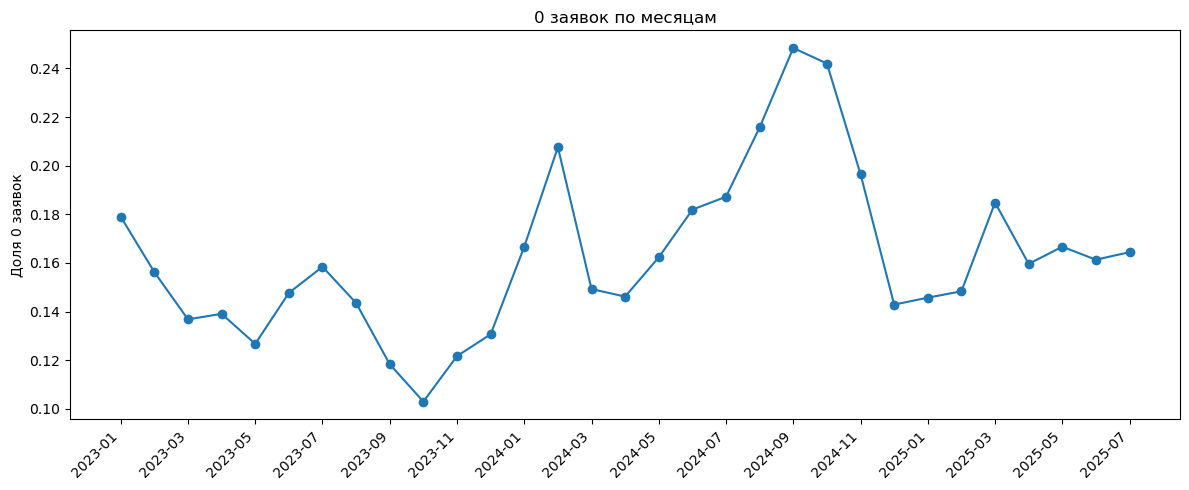

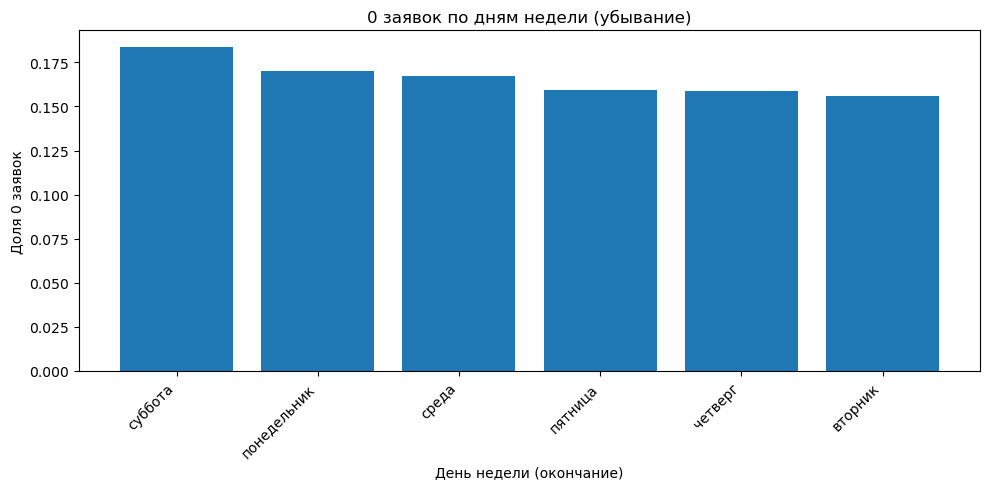

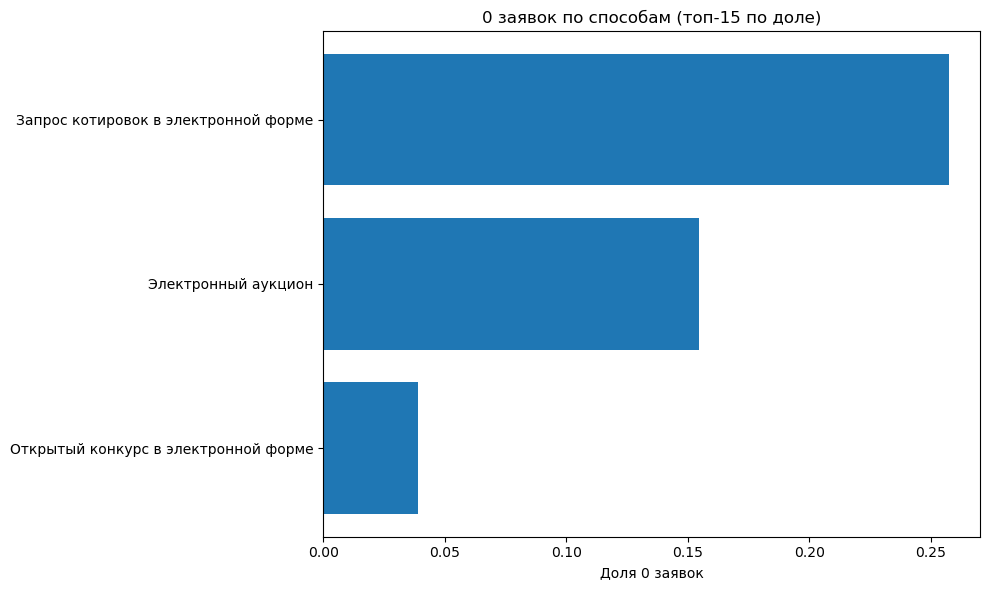

<bound method Axes.set of <Axes: xlabel='День недели (окончание)', ylabel='Доля 1 заявки'>>

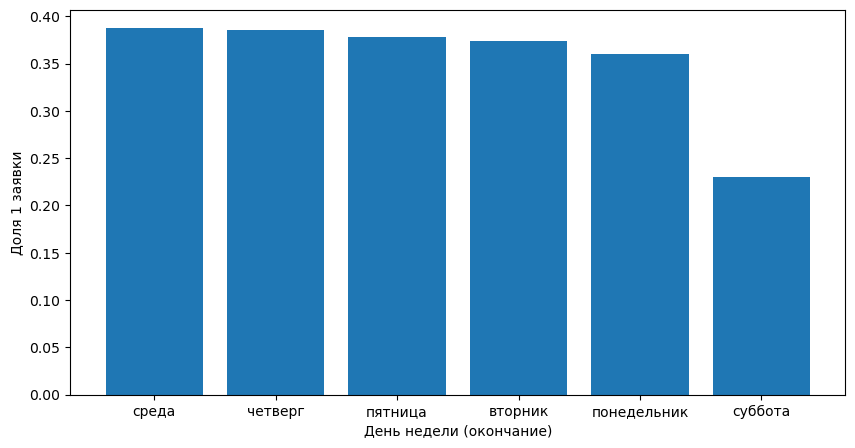

In [1]:
# Использование графиков и матрицы корреляций для поиска критериев, влияющих на успешность закупки

# Фильтруем ДОПЗ = воскресенье.
# Раздельно анализируем **0** и **1** заявку.
# Сортируем категории по убыванию долей.
# Строим графики в matplotlib, сохраняем PNG в `analysis_notebook_assets/figures`.
# Считаем корреляции и зависимость НМЦК ↔ заявки.

## Задача
#### Проанализировать данные о конкурентных закупках за период с 01.01.2023 по 30.06.2025 и понять какие критерие влияют на то, что на закупку подано "0" заявок

## Цель
#### Сократить количество закупок с "0" заявок основываясь на полученных в ходе исследования инсайтах

## 1) Загрузка и подготовка данных

# Импортирую библиотеки для работы с данными
import matplotlib.pyplot as plt #Для визуализации
import numpy as np #Для работы с числами
import pandas as pd #Для работы с dataframe
from pathlib import Path #Для работы с путями и файловой системы
import seaborn as sns # Для матрицы корреляций

pd.set_option('display.max_rows', 50) #Устанавливаю ограничение на максимальное количество отображаемых строк
pd.set_option('display.max_columns', 50) #Устанавливаю ограничение на максимальное количество отображаемых колонок
#Для удобного просмотра данных

#Что бы сохранить графики заблаговременно создаю общую папку "analysis_notebook_assets", в которой соответствеенно ещё 2 подпапки "figures" и "tables"
ASSETS = Path('analysis_notebook_assets')
FIG = ASSETS / 'figures' #Создаю путь для подпапки "figures"
TBL = ASSETS / 'tables' #Создаю путь для подпапки "tables"
FIG.mkdir(parents=True, exist_ok=True) #Создаю папку для графиков
TBL.mkdir(parents=True, exist_ok=True) #Создаю папку для таблиц
#При этом, если папка уже существует, то ошибки не будет

ASSETS.resolve(), FIG.resolve(), TBL.resolve() #Проверяю, правильно ли создались папки (по абсолютному пути).

## Требуется доработка для размещения на github

# Ищем Excel рядом с ноутбуком или по абсолютному пути
candidates = [
    Path('./конкурентные_закупки_2_для_ML_без_совм_торгов.xlsx'),
    Path('конкурентные_закупки_2_для_ML_без_совм_торгов.xlsx'),
    Path('/mnt/data/конкурентные_закупки_2_для_ML_без_совм_торгов.xlsx'),
]
file_path = next((p for p in candidates if p.exists()), None)

if file_path is None:
    # Если файл не найден, попробуем найти любой xlsx файл в текущей директории
    xlsx_files = list(Path('.').glob('*.xlsx'))
    if xlsx_files:
        file_path = xlsx_files[0]
        print(f"Файл не найден по стандартным путям, используем: {file_path}")
    else:
        raise FileNotFoundError("Положите Excel-файл 'конкурентные_закупки_2_для_ML_без_совм_торгов.xlsx' рядом с ноутбуком.")

try:
    sheet = pd.ExcelFile(file_path).sheet_names[0]
    df = pd.read_excel(file_path, sheet_name=sheet)
    print(f"Файл успешно загружен: {file_path}, лист: {sheet}")
except Exception as e:
    raise Exception(f"Ошибка при чтении файла: {e}")

df.shape, sheet, df.head(3)

## Подготовка

rename = {
    '№': 'row_id',
    'НмЦК': 'nmck',
    'Дата размещения первой версии извещения': 'date_notice',
    'День недели даты размещения первой версии извещения': 'dow_notice',
    'Месяц даты размещения первой версии извещения': 'month_notice',
    'Дата и время окончания срока подачи заявок': 'date_deadline',
    'День недели даты окончания срока подачи заявок': 'dow_deadline',
    'Месяц даты окончания срока подачи заявок': 'month_deadline',
    'Способ определения поставщика': 'proc_method',
    'ОКПД 2. Группа (3-ий уровень)': 'okpd2_group',
    'ОКПД 2. Код группы (3-ий уровень)': 'okpd2_group_code',
    'Количество поданных заявок': 'bids_cnt',
}
dfw = df.rename(columns=rename).copy()

# Преобразуем даты, если они еще не в datetime формате
date_columns = ['date_notice', 'date_deadline']
for col in date_columns:
    if col in dfw.columns and not pd.api.types.is_datetime64_any_dtype(dfw[col]):
        dfw[col] = pd.to_datetime(dfw[col], errors='coerce')

dfw['year'] = dfw['date_deadline'].dt.year
dfw['month_num'] = dfw['date_deadline'].dt.month
dfw['ym'] = dfw['date_deadline'].dt.to_period('M').astype(str)

dfw['is_zero'] = (dfw['bids_cnt'] == 0).astype(int)
dfw['is_one']  = (dfw['bids_cnt'] == 1).astype(int)

# Фильтр воскресений
before = len(dfw)
sunday_mask = dfw['dow_deadline'].astype(str).str.lower().str.strip().eq('воскресенье')
removed = int(sunday_mask.sum())
dfw = dfw.loc[~sunday_mask].reset_index(drop=True)
after = len(dfw)

print(f"Удалено строк (ДОПЗ=воскресенье): {removed}. Осталось: {after} из {before}.")
dfw.head(2)

## Агрегаты

def make_aggr(flag: str):
    month = (dfw.groupby(['year','month_num','month_deadline'])
             .agg(rate=(flag,'mean'), n=('row_id','count'))
             .reset_index().sort_values(['year','month_num']))
    month['ym'] = month['year'].astype(str) + '-' + month['month_num'].astype(str).str.zfill(2)
    dow = (dfw.groupby('dow_deadline')
           .agg(rate=(flag,'mean'), n=('row_id','count'))
           .reset_index().sort_values('rate', ascending=False))
    method = (dfw.groupby('proc_method')
              .agg(rate=(flag,'mean'), n=('row_id','count'))
              .reset_index().sort_values('rate', ascending=False))
    okpd2 = (dfw.groupby(['okpd2_group_code','okpd2_group'])
             .agg(rate=(flag,'mean'), n=('row_id','count'))
             .reset_index().sort_values('rate', ascending=False))
    return month, dow, method, okpd2

m0, d0, pm0, ok0 = make_aggr('is_zero')
m1, d1, pm1, ok1 = make_aggr('is_one')

m0.head(3), d0.head(3), pm0.head(3), ok0.head(3)

## Графики

def save_show(fig, name):
    path = FIG / name
    fig.savefig(path, bbox_inches='tight', dpi=160)
    plt.show()
    plt.close(fig)
    return path

# 0 заявок по месяцам
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
ax.plot(m0['ym'], m0['rate'], marker='o')
ax.set_xticks(np.arange(0, len(m0['ym']), max(1, len(m0)//12)))
ax.set_xticklabels(m0['ym'].values[::max(1, len(m0)//12)], rotation=45, ha='right')
ax.set_ylabel('Доля 0 заявок')
ax.set_title('0 заявок по месяцам')
plt.tight_layout()
save_show(fig, 'zero_rate_by_month.png')

# 0 заявок по дням недели (убывание)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.bar(d0['dow_deadline'], d0['rate'])
ax.set_xlabel('День недели (окончание)')
ax.set_ylabel('Доля 0 заявок')
ax.set_title('0 заявок по дням недели (убывание)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
save_show(fig, 'zero_by_weekday_desc.png')

# 0 заявок по способам (топ-15 по доле)
top = pm0.head(15).copy()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.barh(top['proc_method'], top['rate'])
ax.set_xlabel('Доля 0 заявок')
ax.set_title('0 заявок по способам (топ-15 по доле)')
plt.gca().invert_yaxis()
plt.tight_layout()
save_show(fig, 'zero_by_method_top15_rate.png')

# 1 заявка по дням недели
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.bar(d1['dow_deadline'], d1['rate'])
ax.set_xlabel('День недели (окончание)')
ax.set_ylabel('Доля 1 заявки')
ax.set